In [1]:
! pip install kaggle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 90% 257M/285M [00:00<00:00, 425MB/s]
100% 285M/285M [00:00<00:00, 365MB/s]


In [7]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D

import os

In [16]:


data = pd.read_csv('/content/icml_face_data.csv')

emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [18]:
data


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [19]:
# Function to parse data into right format
# Output: Image in right shaped and normalized + labels
def parse_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))
        image_array[i] = image

    return image_array, image_label

# Splitting the data into train, validation and testing set thanks to Usage column
train_imgs, train_lbls = parse_data(data[data[" Usage"] == "Training"])
val_imgs, val_lbls = parse_data(data[data[" Usage"] == "PrivateTest"])
test_imgs, test_lbls = parse_data(data[data[" Usage"] == "PublicTest"])

In [ ]:
print("train shape", np.shape(train_imgs))
print("validation shape", np.shape(val_imgs))
print("validatio shape", np.shape(test_imgs))

train shape (28709, 48, 48, 1)
validation shape (3589, 48, 48, 1)
validatio shape (3589, 48, 48, 1)


In [20]:
train_imgs_new = train_imgs / 255
val_imgs_new = val_imgs / 255

In [21]:
# Create an image generator for augmentation
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_loader = train_datagen.flow(train_imgs_new, train_lbls, batch_size=64)

In [22]:
def entry_flow(inputs):

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x


def middle_flow(x, num_blocks=8):

    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x


def exit_flow(x, num_classes=7):

    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    return layers.Dense(num_classes, activation=activation)(x)

inputs = keras.Input(shape=(48, 48, 1))  # Variable-size image inputs.
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = keras.Model(inputs, outputs)

In [23]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = xception
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 24, 24,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 24, 24,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     18,496 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 24, 24,    │          0 │ activation_1[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 24, 24,    │      8,896 │ activation_2[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 24, 24,    │     17,664 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │      8,320 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 12,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 12, 12,    │          0 │ add[0][0]       

 Total params: 20,893,967 (79.70 MB)

 Trainable params: 20,843,711 (79.51 MB)

 Non-trainable params: 50,256 (196.31 KB)

In [24]:
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer=keras.optimizers.Adam(0.001),
            metrics=['accuracy'])

In [27]:
h1 = cnn.fit(train_loader,
             batch_size=64,
             epochs=1,
             validation_data=(val_imgs_new, val_lbls), verbose=1)

449/449 ━━━━━━━━━━━━━━━━━━━━ 2439s 5s/step - accuracy: 0.4156 - loss: 1.5019 - val_accuracy: 0.1190 - val_loss: 4.0640


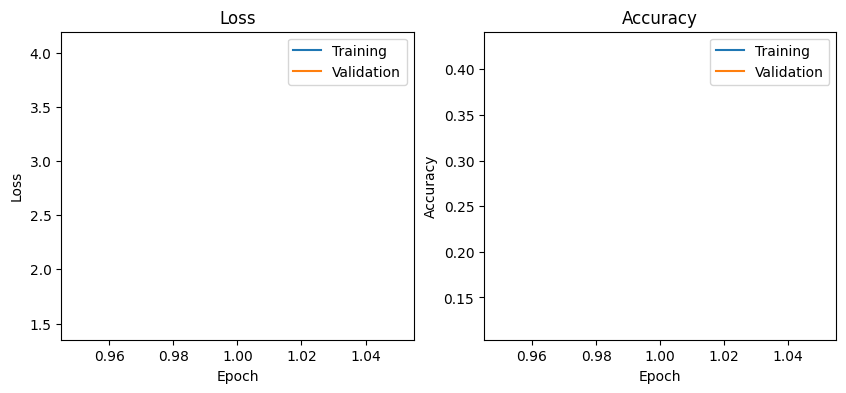

In [28]:
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [35]:
!pip install torch torchvision wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [36]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nurch22 (nurch22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [37]:
wandb.init(project="my-neural-network", config={
    "epochs": 5,
    "batch_size": 64,
    "lr": 0.001,
    "architecture": "CNN",
})

In [38]:
config = wandb.config


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()
wandb.watch(model, log="all")  # logs gradients, parameters, and model structure
